# Revision

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn.uv import *
# from nnn import train_nn as tnn
from pprint import pprint

In [2]:
notebook_name = '01.6_Revision'
figdir = os.path.join('./fig', notebook_name)
figpath = lambda x: os.path.join('./fig', notebook_name, x)

In [3]:
# mydata = tnn.MyData()
# mydata.load_everything()

In [4]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)
agg_result_file='./data/uv_melt/uvmelt_agg.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_2024.tsv', index_col=0)

ecl_oligo_df = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos.csv', index_col=0)

# Clean up the variant annotation file

Clean up the annotation file:

- Drop duplicated variants

- Remove variants not really used for DNA experiment

- Unify SEQID to upper case

**Input:**

- `./data/annotation/NNNlib2b_annotation_20220519.tsv`


**Output:**

- `./data/annotation/NNNlib2b_annotation_2024.tsv`

- `./data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv`

In [67]:
# File names
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
new_annotation_file = './data/annotation/NNNlib2b_annotation_2024.tsv'

In [93]:
# Read in the 220519 annotation file
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv', index_col=0)

# Unify all sequences to upper case
annotation['RefSeq'] = annotation.RefSeq.apply(lambda x: x.upper())

# Remove excessive (duplicated) VARloops
# annotation = annotation.loc[[seqid for seqid in annotation.index if not seqid.startswith('VAR')]]

# Remove pseudoknots and Pumillo RBP binding variants as they are for RNA and not really analyzed
annotation = annotation.query('ConstructType != "PUMcontrols" & ConstructType != "pseudoknots" & ConstructType != "pseudoknot_pt_muts"')

# Remove duplicated WBcontrols (only keep WB but not WB_controls...)
annotation.rename(index={'WB_controls260831':'WB7'}, inplace=True)
# annotation = annotation.loc[[seqid for seqid in annotation.index if (not seqid.startswith('WB')) or seqid.startswith('WB_')]]
annotation = annotation.loc[[seqid for seqid in annotation.index if (not seqid.startswith('WB')) or (not '_controls' in seqid)]]

# Save the new annotation file
annotation.to_csv(new_annotation_file, sep='\t')

In [92]:
annotation.rename(index={'WB_controls260831':'WB7'}, inplace=True)

In [94]:
# Print accounting numbers
print('\n~~~~~~~~~~Annotation file~~~~~~~~~~~\n')
print('\n============', 'TOTAL', '============')
print('All: %d\tUnique: %d' %
     (len(annotation), len(np.unique(annotation.RefSeq))))
for seq_class in np.unique(annotation.Series):
    print('\n============', seq_class, '============')
    print('All: %d\tUnique: %d' % 
          (len(annotation.query(f'Series == "{seq_class}"')), len(np.unique(annotation.query(f'Series == "{seq_class}"').RefSeq))))


~~~~~~~~~~Annotation file~~~~~~~~~~~


============ TOTAL ============
All: 41311	Unique: 40234

============ Bulges ============
All: 11520	Unique: 10880

============ Control ============
All: 595	Unique: 594

============ External ============
All: 32	Unique: 32

============ MisMatches ============
All: 18240	Unique: 17856

============ TETRAloop ============
All: 6144	Unique: 6144

============ TRIloop ============
All: 1536	Unique: 1536

============ VARloop ============
All: 172	Unique: 136

============ WatsonCrick ============
All: 3072	Unique: 3072


The annotation file `NNNlib2b_annotation_2024_duplicates_dropped.tsv` was made by dropping duplicates in `NNNlib2b_annotation_2024.tsv`.

In [38]:
annotation_file = './data/annotation/NNNlib2b_annotation_2024.tsv'
new_annotation_file = './data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv'
annotation = fileio.read_annotation(annotation_file)
annotation_unique = annotation.drop_duplicates(subset=['RefSeq'], keep='last')
annotation_unique.to_csv(new_annotation_file, sep='\t')

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


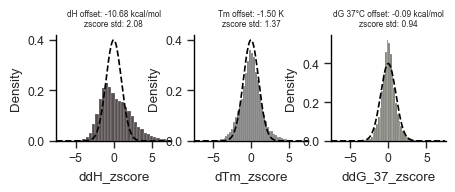

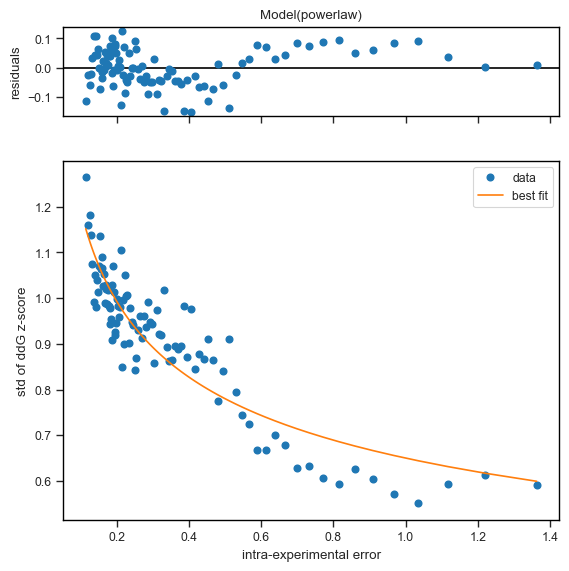

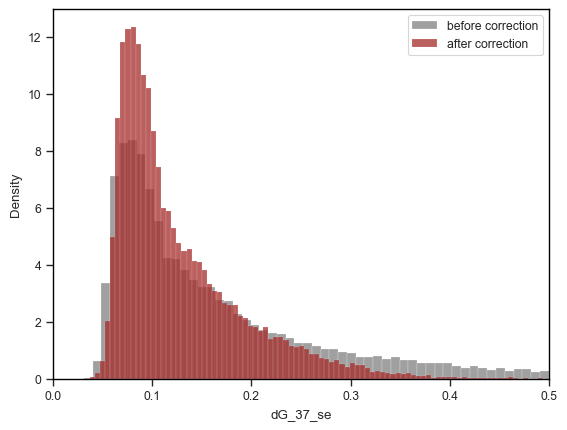

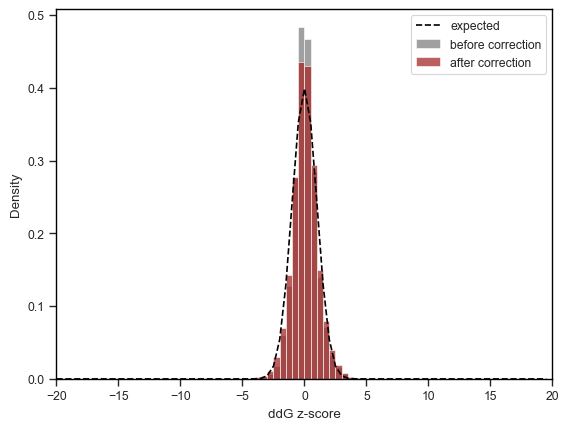

In [76]:
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)

In [74]:
'WB3' in arr.index.tolist(), 'WB_controls260871' in arr.index.tolist()

(True, False)

In [75]:
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr_v0 = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr_v0 = arr_v0.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])
# arr_v0.rename(index={'WB3':'WB_controls260871'}, inplace=True)
print(arr_v0.shape)
arr_v0.to_csv(os.path.join('./data/models/raw', 'arr_v0_n=%d.csv' % arr_v0.shape[0]))

(30751, 42)


In [9]:
# Make the index in the data file compliant with the annotation file
arr_v0.rename(index={'WB3':'WB_controls260871'}, inplace=True)
arr_v1.rename(index={'WB3':'WB_controls260871'}, inplace=True)
arr_v1_1M.rename(index={'WB3':'WB_controls260871'}, inplace=True)

In [10]:
annotation.to_csv(new_annotation_file, sep='\t')
arr_v0.to_csv('./data/models/raw/arr_v0_n=30872.csv')
arr_v1.to_csv('./data/models/raw/arr_v1_n=27732.csv')
arr_v1_1M.to_csv('./data/models/processed/arr_v1_1M_n=27732.csv')

## Reproducibility of array and UV melting

### Load data

In [5]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

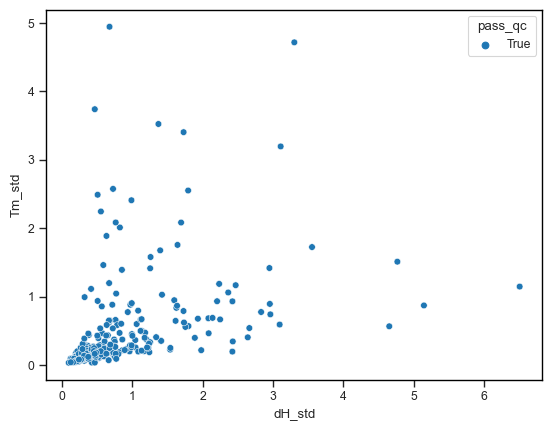

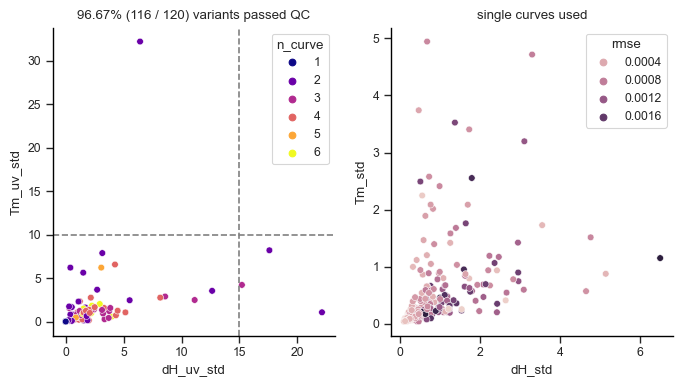

In [6]:
sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230907.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=False)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

75.87% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v10.CPvariant.gz
75.87% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


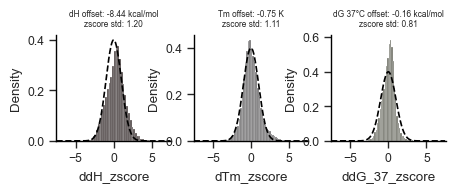

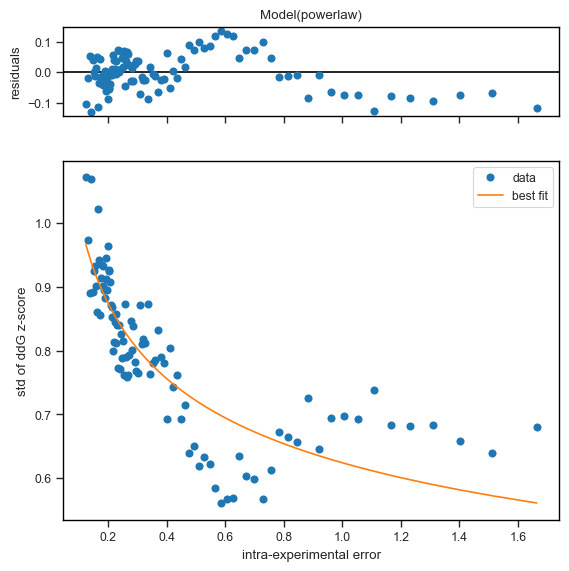

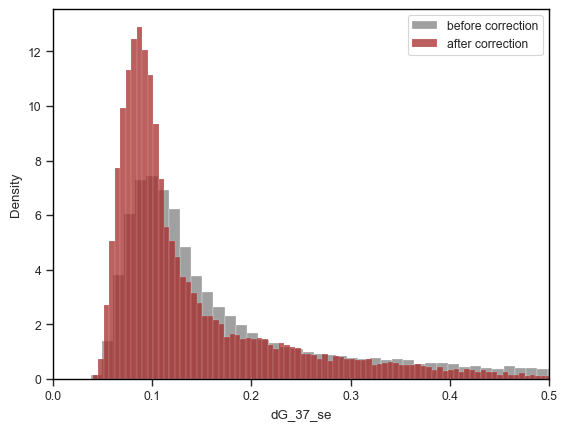

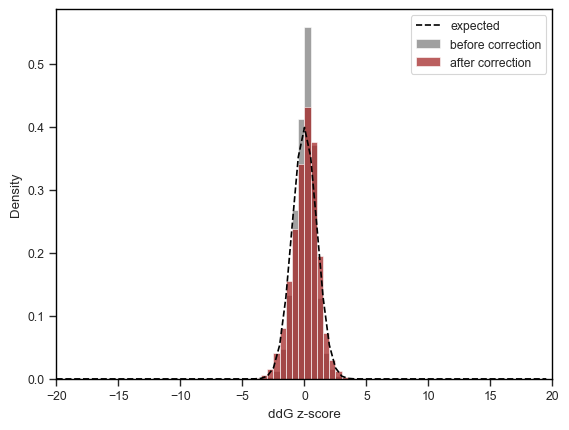

In [7]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))

### Replicates on different days

Salt correct all to one concentration:

In [22]:
uv_rep_df = result_df.query('rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120')
uv_rep_df = uv_rep_df.set_index('SEQID').join(annotation[['RefSeq']])
uv_rep_df['GC'] = uv_rep_df['RefSeq'].apply(util.get_GC_content)
uv_rep_df['dG_37_adj'] = uv_rep_df.apply(lambda row: util.get_Na_adjusted_dG_37(
    Tm=row.Tm, dH=row.dH, GC=row.GC, Na=0.075, from_Na=(row.Na_mM + 50)/1000), axis=1)
uv_rep_df = uv_rep_df.groupby(['SEQID', 'curve_date'])[['dG_37_adj']].apply(np.mean).reset_index()
uv_rep_df = uv_rep_df[uv_rep_df.duplicated(subset=['SEQID'], keep=False)]

both_ids = [x for x in np.unique(uv_rep_df.SEQID) if not x.startswith('HP')]
arr_rep_df = arraydata.data_all.loc[both_ids, ['dG_37-r%d'%x for x in [1,2,3]]]
arr_rep_df = arr_rep_df.reset_index().melt(id_vars='SEQID').sort_values('SEQID')

uv_rep_df = uv_rep_df.loc[uv_rep_df.SEQID.apply(lambda x: not x.startswith('HP'))]

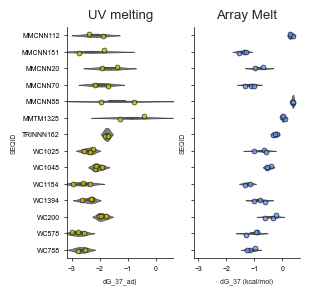

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(3,3), sharex=True, sharey=True)

sns.violinplot(data=uv_rep_df, y='SEQID', x='dG_37_adj', 
              linewidth=.5, color='gray',
              ax=ax[0])
sns.stripplot(data=uv_rep_df, y='SEQID', x='dG_37_adj', 
              marker='.', c='y', size=7, edgecolor='k', linewidth=.5,
              alpha=.8, ax=ax[0])
ax[0].set_title('UV melting')

sns.violinplot(data=arr_rep_df, y='SEQID', x='value', 
              color='gray', linewidth=.5,
              ax=ax[1])
sns.stripplot(data=arr_rep_df, y='SEQID', x='value', 
              marker='.', c='cornflowerblue', size=7, edgecolor='k', linewidth=.5,
              alpha=.8, ax=ax[1])
ax[1].set_title('Array Melt')
plt.xlabel('dG_37 (kcal/mol)')
util.beutify_all_ax(ax, x_locator = 1, shrink=True, do_not_resize=True)
util.save_fig(figpath('salt_corrected_UV_melt_vs_array_reproducibility_over_days_stripplot.pdf'))

### Single UV curves

In [24]:
uv_rep_df = result_df.query('Na_mM == 25').query('rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120')
uv_rep_df = uv_rep_df[uv_rep_df.duplicated(subset=['SEQID'], keep=False)].sort_values('dG_37')

uv_rep_df['cuvette'] = uv_rep_df.apply(lambda row: str(row.curve_date)+'_'+str(row.curve_num), axis=1)

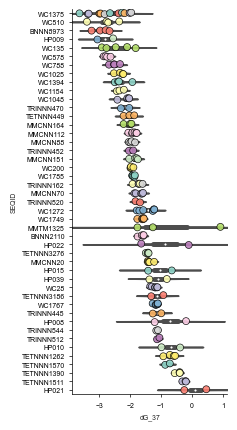

In [25]:
fig, ax = plt.subplots(figsize=(2,5))
sns.violinplot(data=uv_rep_df, y='SEQID', x='dG_37', color='gray', ax=ax)
sns.stripplot(data=uv_rep_df, y='SEQID', x='dG_37', hue='cuvette',
              marker='.', size=10, edgecolor='k', linewidth=.5, palette='Set3',
              alpha=.9, ax=ax)
ax.get_legend().remove()
util.beutify(ax, shrink=True, do_not_resize=True)
util.save_fig(figpath('single_curve_by_cuvette_UV_melt_reproducibility_stripplot.pdf'))

### Strand concentrations

In [26]:
result_agg_df.sort_values('curve_date')

,SEQID,curve_date,curve_num,dH_uv,dH_uv_std,n_curve,Tm_uv,Tm_uv_std,dG_37_uv,dG_37_uv_std,dS_uv,dS_uv_std,is_hairpin,Na_mM,conc_uM,Purification
14,HP018,23020411,6,-38.331193,0.000000,1,62.145979,0.000000,-2.874700,0.000000,-0.114320,0.000000,True,25.0,6.0,standard desalting
11,HP014,23020411,2,-29.188951,0.000000,1,39.230761,0.000000,-0.208443,0.000000,-0.093440,0.000000,True,25.0,6.0,standard desalting
12,HP015,23020411,3,-29.711657,0.396712,2,48.281266,6.199074,-1.042789,0.780775,-0.092435,0.002168,True,25.0,6.0,standard desalting
13,HP016,23020411,4,-23.410537,0.000000,1,48.590226,0.000000,-0.843331,0.000000,-0.072762,0.000000,True,25.0,6.0,standard desalting
16,HP021,23020517,3,-27.307065,1.508616,2,35.965614,5.617608,0.091377,2.194315,-0.088339,0.005138,True,25.0,6.0,standard desalting
18,HP023,23020517,5,-33.696133,0.000000,1,28.400352,0.000000,0.960950,0.000000,-0.111743,0.000000,True,25.0,6.0,standard desalting
15,HP019,23020517,1,-44.254994,0.000000,1,28.323514,0.000000,1.273670,0.000000,-0.146796,0.000000,True,25.0,6.0,standard desalting
40,MMTM176,23020906,5,-33.259670,0.000000,1,60.404827,0.000000,-2.333760,0.000000,-0.099713,0.000000,True,25.0,6.0,standard desalting
36,MMCNNN2336,23020906,2,-51.039304,0.000000,1,60.131877,0.000000,-3.542452,0.000000,-0.153142,0.000000,True,25.0,6.0,standard desalting
54,TETNNN1696,23021722,6,-25.233867,0.000000,1,44.488611,0.000000,-0.594911,0.000000,-0.079442,0.000000,True,25.0,6.0,standard desalting


## ssfluor controls

In [236]:
df = fileio.read_pickle('./data/series_merged/NNNlib2b_DNA_20211221.pkl')

In [237]:
df = df.merge(annotation['ConstructType'], on='SEQID')

In [238]:
np.unique(df.ConstructType)

array(['AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos', 'NNN', 'NNN_3primebulge', 'NNN_5prime_bulge',
       'PUMcontrols', 'PolyNTControls', 'RepeatControls', 'SuperStem',
       'WBcontrols', 'WC_5ntstem', 'WC_6ntstem', 'WC_7ntstem',
       'pseudoknots'], dtype=object)

In [17]:
np.unique(arraydata.curve['r1'].join(annotation['ConstructType']).ConstructType)

array(['3mer', 'AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos', 'NN', 'NNN', 'NNN_3primebulge',
       'NNN_5prime_bulge', 'NN_3primebulge', 'NN_5primebulge',
       'PUMcontrols', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p',
       'StemDangle_53p', 'StemDangle_5p', 'VARloop', 'VariableLoops',
       'WBcontrols', 'WC_5ntstem', 'WC_6ntstem', 'WC_7ntstem',
       'pseudoknot_pt_muts'], dtype=object)

In [239]:
df = pd.read_csv('./data/series/NNNlib2b_DNA_tile1_focused_green_2_600ms.CPseries.json.csv')
df = df.merge(annotation['ConstructType'], on='SEQID')
ssfluor_df = df.query('ConstructType == "ssfluor"')

In [240]:
ssfluor_df['nuc'] = ssfluor_df.RefSeq.apply(lambda x: x[:3])

In [254]:
ssfluor_grouped_df = ssfluor_df.groupby('nuc').apply(np.median)

TypeError: '<' not supported between instances of 'float' and 'str'

In [253]:
cols = ssfluor_grouped_df.columns[2:]
ssfluor_grouped_df[cols] = ssfluor_grouped_df[cols].values / ssfluor_grouped_df['Green07_Cy3'].values.reshape(64,1)

KeyError: 'Green08_Quench'

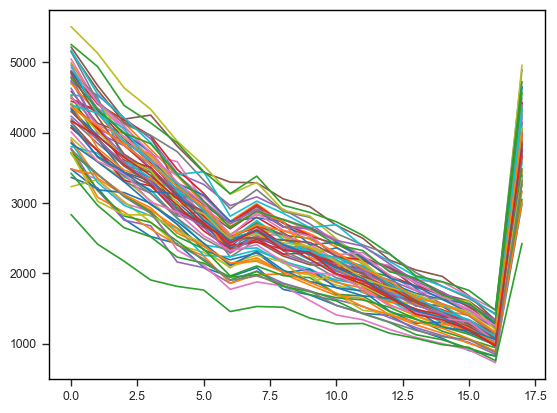

In [252]:
plt.plot(ssfluor_grouped_df[cols].values.T)
plt.show()

In [242]:
ssfluor_df

,clusterID,Green07_Cy3,Green09_Quench,Green12_20.0,Green13_22.5,Green14_25.0,Green15_27.5,Green16_30.0,Green17_32.5,Green18_35.0,...,Green25_52.5,Green26_55.0,Green27_57.5,Green28_60.0,Green29_20.0,RefSeq,SEQID,Series,ConstructType,nuc
817,M00653:160:000000000-K4R35:1:2101:17841:2000,2010.605974,1789.877135,3693.822317,2988.802393,2787.492107,2785.247144,2295.730884,2141.064764,1975.032858,...,1334.303988,1078.358115,948.004514,698.390657,3020.470829,CCGAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC23,Control,ssfluor,CCG
818,M00653:160:000000000-K4R35:1:2101:19349:4761,1933.609098,1988.670794,4836.090933,4027.687372,3507.685470,2980.492760,2396.324513,2455.168893,2356.714182,...,1199.892283,1091.843277,979.510413,753.826541,4281.442912,CCGAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC23,Control,ssfluor,CCG
819,M00653:160:000000000-K4R35:1:2101:14566:5135,1607.582806,1578.999265,4153.517149,3704.715318,3259.436665,3160.263840,2977.654289,2639.966614,2080.786067,...,1287.058233,1076.411125,1207.690206,1275.752442,3691.872959,CCGAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC23,Control,ssfluor,CCG
820,M00653:160:000000000-K4R35:1:2101:11802:5455,1292.722517,1242.808864,2761.061015,2603.326584,1883.095072,2205.522753,1715.576859,1773.850313,1470.881750,...,741.315102,712.769550,716.127909,498.887114,2186.393645,CCGAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC23,Control,ssfluor,CCG
821,M00653:160:000000000-K4R35:1:2101:17437:5640,1123.858922,836.610373,2330.255414,2091.454883,1685.068670,1379.883577,1388.135245,1154.910976,917.177063,...,603.960885,499.842439,498.897797,354.970255,2005.251781,CCGAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC23,Control,ssfluor,CCG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70232,M00653:160:000000000-K4R35:1:2101:5524:20313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,TGTAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC46,Control,ssfluor,TGT
70233,M00653:160:000000000-K4R35:1:2101:8729:21543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,TGTAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC46,Control,ssfluor,TGT
70234,M00653:160:000000000-K4R35:1:2101:20887:21628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,TGTAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC46,Control,ssfluor,TGT
70235,M00653:160:000000000-K4R35:1:2101:22754:22538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,TGTAACAACAACAACAACAACAACAACAACAACAACAAC,SSFC46,Control,ssfluor,TGT


## Clean up the annotation file

In [7]:
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv', index_col=0)
new_annotation_file = './data/annotation/NNNlib2b_annotation_2024.tsv'
new_annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_2024.tsv', index_col=0)

75.87% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v10.CPvariant.gz
75.87% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


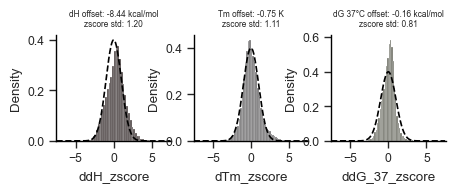

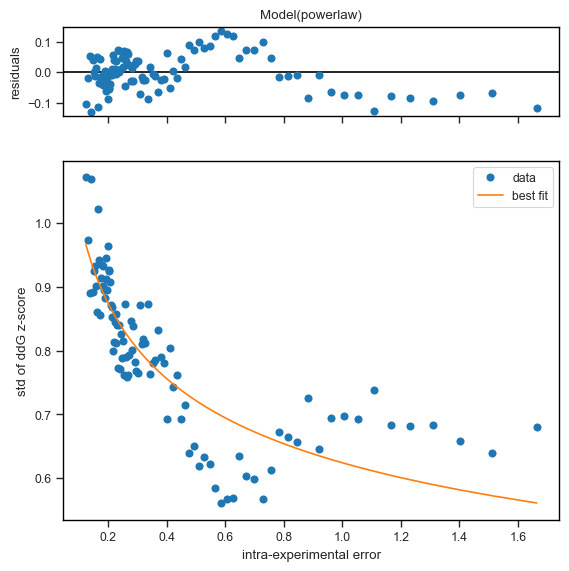

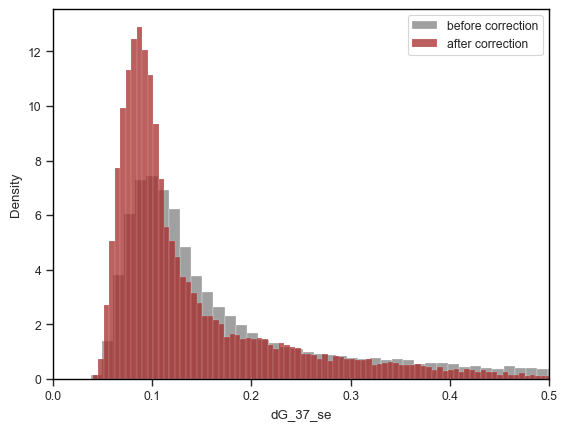

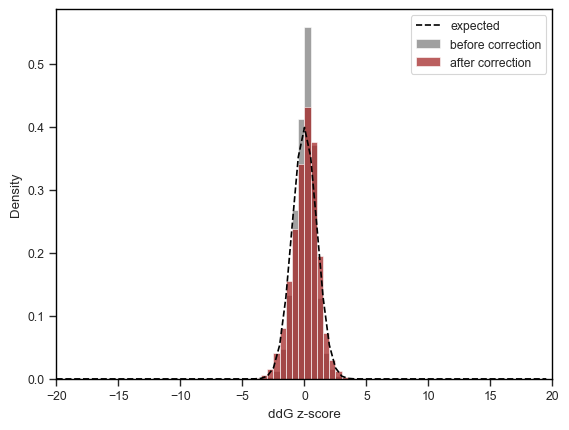

In [130]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)
arr_v0 = pd.read_csv('./data/models/raw/arr_v0_n=30872.csv', index_col=0)
arr_v1 = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_v1_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)

In [145]:
excluded_construct_type = ['pseudoknot_pt_muts', 'PUMcontrols']
arr_v0 = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr_v0 = arr_v0.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])
arr_v0.rename(index={'WB3':'WB_controls260871'}, inplace=True)
print(arr_v0.shape)
arr_v0.to_csv(os.path.join('./data/models/raw', 'arr_v0_n=%d.csv' % arr_v0.shape[0]))

(30978, 42)


In [131]:
# Unify all sequences to upper case
annotation['RefSeq'] = annotation.RefSeq.apply(lambda x: x.upper())

# Remove VARloops that are not really there
annotation = annotation.loc[[seqid for seqid in annotation.index if not seqid.startswith('VAR')]]

# Remove pseudoknots and Pumillo RBP binding variants as they are not really analyzed
annotation = annotation.query('ConstructType != "PUMcontrols" & ConstructType != "pseudoknots" & ConstructType != "pseudoknot_pt_muts"')

# Remove repetitive WBcontrols
annotation = annotation.loc[[seqid for seqid in annotation.index if (not seqid.startswith('WB')) or seqid.startswith('WB_')]]

# Make the index in the data file compliant with the annotation file
arr_v0.rename(index={'WB3':'WB_controls260871'}, inplace=True)
arr_v1.rename(index={'WB3':'WB_controls260871'}, inplace=True)
arr_v1_1M.rename(index={'WB3':'WB_controls260871'}, inplace=True)

In [132]:
annotation.to_csv(new_annotation_file, sep='\t')
arr_v0.to_csv('./data/models/raw/arr_v0_n=30872.csv')
arr_v1.to_csv('./data/models/raw/arr_v1_n=27732.csv')
arr_v1_1M.to_csv('./data/models/processed/arr_v1_1M_n=27732.csv')

In [144]:
for df in [annotation, arr, arr_v0, arr_v1]:
    print(len(df), len(np.unique(df.RefSeq)))

41171 40130
31101 31101
30978 30978
27732 27732


In [135]:
for seq_class in np.unique(annotation.Series):
    print('\n', seq_class)
    for df in [annotation, arr, arr_v0, arr_v1]:
        print(len(df.query(f'Series == "{seq_class}"')), len(np.unique(df.query(f'Series == "{seq_class}"').RefSeq)))


 Bulges
11520 10880
9708 9708
9708 9708
9097 9097

 Control
595 594
106 106
106 106
0 0

 External
32 32
143 143
143 143
19 19

 MisMatches
18240 17856
11433 11433
11433 11433
10725 10725

 TETRAloop
6144 6144
5652 5652
5652 5652
4691 4691

 TRIloop
1536 1536
1440 1440
1440 1440
1168 1168

 VARloop
32 32
17 17
17 17
5 5

 WatsonCrick
3072 3072
2602 2602
2602 2602
2027 2027


In [138]:
df = arr_v0
seq_class = 'External'
np.unique(df.query(f'Series == "{seq_class}"').ConstructType)

array(['BaeControls', 'PUMcontrols', 'WBcontrols', 'pseudoknot_pt_muts'],
      dtype=object)

In [18]:
def check_df_diff(df1, df2):
    # return pd.concat([df1, df2]).drop_duplicates(keep=False, ignore_index=True)
    return pd.concat([df1.reset_index(), df2.reset_index()]).drop_duplicates(keep=False, ignore_index=True)

In [15]:
arr_v0_30872 = pd.read_csv('./data/models/raw/arr_v0_n=30872.csv', index_col=0)
arr_v0_30863 = pd.read_csv('./data/models/raw/arr_v0_n=30863.csv', index_col=0)

check_df_diff(arr_v0_30872, arr_v0_30863)

,SEQID,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
0,VAR1,-12.902622,2.027848,-17.828146,-10.230760,54.279944,4.497456,44.930533,62.067388,-0.669630,...,-1.041513,((....)),-0.84,-0.809242,-0.714050,62.500000,45.186043,-0.411442,-16.0,-0.048880
1,VAR45,-34.666319,8.318789,-53.146571,-19.553041,60.230678,2.045054,55.476879,63.839446,-2.382943,...,-5.215415,((........)),1.13,-4.454826,-4.157297,75.000000,12.190441,1.530271,-17.6,-0.060390
2,VAR47,-26.212047,5.634624,-41.531596,-18.953544,52.552525,2.572008,46.545943,56.395255,-1.244589,...,-4.318463,((.........)),1.13,-3.560380,-3.264435,69.230769,11.701521,1.563106,-17.6,-0.060390
3,VAR49,-24.250715,5.816776,-38.882539,-17.452559,45.657784,2.859158,40.891720,50.634368,-0.651440,...,-3.631629,((..........)),1.13,-2.881807,-2.590738,64.285714,11.283778,1.591251,-17.6,-0.060390
4,VAR51,-22.633814,5.538407,-35.529610,-15.344050,40.147117,2.798879,36.665983,47.034102,-0.228376,...,-3.338805,((...........)),1.23,-2.595177,-2.307839,60.000000,9.452036,1.715643,-17.6,-0.060713
5,VAR53,-24.534543,6.217685,-43.185388,-17.942465,37.712841,1.296061,35.309428,40.037517,-0.053274,...,-3.338056,((............)),1.33,-2.594212,-2.306773,56.250000,7.687783,1.836986,-17.6,-0.061035
6,VAR55,-17.448293,5.104732,-34.974347,-12.099081,31.811261,4.243502,23.994224,41.047176,0.309509,...,-3.335055,((.............)),1.43,-2.589680,-2.301588,52.941176,5.981257,1.955818,-17.6,-0.061357
7,VAR84,-22.166976,6.070583,-39.026358,-14.997992,42.683910,2.789499,40.159838,48.520071,-0.430147,...,-2.360611,((........)),2.22,-1.923885,-1.698488,41.666667,-15.058104,2.662490,-13.2,-0.049718
8,VAR86,-18.553340,5.103550,-30.925063,-12.559271,29.112833,3.654289,23.585440,36.385364,0.470431,...,-1.528999,((.........)),2.22,-1.155698,-0.969601,38.461538,-15.280516,2.676171,-13.2,-0.049718


In [24]:
arr_v1_27732

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
SEQID,,,,,,,,,,,,,,,,,,,,,
BC1,-29.405457,2.259464,-39.583422,-22.635332,43.745758,0.448672,42.451361,45.010831,-1.031010,0.063069,...,-5.630936,((((((....)))))),-5.38,-4.688133,-4.283077,43.750000,66.346868,-3.898545,-45.1,-0.128067
BC10,-13.860604,6.090826,-40.334697,-7.611236,19.970895,1.921306,15.557824,27.646350,0.784015,0.409934,...,-1.594503,(((.((....)).))),-0.10,-1.167094,-1.034802,37.500000,27.562143,0.900750,-28.7,-0.092213
BC11,-19.310492,6.175993,-40.411542,-11.712279,24.234945,1.821857,20.111575,29.321448,0.799597,0.400100,...,-3.791497,(((.((....)).))),-3.34,-2.876428,-2.557364,43.750000,54.749507,-2.078628,-38.4,-0.113042
BC15,-28.359914,2.648732,-38.883415,-21.838619,31.556180,0.680925,29.854361,33.653719,0.523107,0.098943,...,-3.409790,((((.((....)).)))),-2.62,-2.471721,-2.176915,44.444444,51.193660,-1.501008,-34.3,-0.102144
BC16,-27.266132,5.913166,-51.558953,-14.639782,26.229147,1.780851,22.129733,33.527041,0.952244,0.370833,...,-3.380627,((((.((....)).)))),-2.62,-2.410764,-2.101205,44.444444,50.821835,-1.484696,-34.8,-0.103756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
varloop257581,-29.733194,2.724231,-39.369022,-22.523638,56.350862,1.252395,52.801659,60.852077,-1.717710,0.107837,...,-6.224229,((...........)),1.23,-5.185212,-4.809472,66.666667,10.008263,1.677700,-17.6,-0.060713
varloop257601,-26.345117,3.277633,-39.706480,-19.440711,40.492735,0.908829,38.219125,43.781862,-0.325330,0.071060,...,-5.250290,((..............)),1.43,-4.222346,-3.852054,61.111111,6.646542,1.909319,-17.6,-0.061357
varloop257621,-25.128278,2.998856,-37.745495,-18.452277,35.096619,0.880154,33.089326,38.058575,0.152467,0.084654,...,-5.141857,((.................)),1.73,-4.110832,-3.739269,57.142857,2.095381,2.231904,-17.6,-0.062325


In [23]:
arr_v1_27259

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
SEQID,,,,,,,,,,,,,,,,,,,,,
BC1,-25.430247,2.255642,-35.912486,-19.078323,50.396977,1.116339,46.229170,54.563746,-1.066146,0.062352,...,-5.630936,((((((....)))))),-5.38,-4.688133,-4.283077,43.750000,66.346868,-3.898545,-45.1,-0.128067
BC10,-15.188329,5.657807,-43.969039,-8.172837,21.158312,1.480272,17.214121,28.022211,0.832575,0.378496,...,-1.594503,(((.((....)).))),-0.10,-1.167094,-1.034802,37.500000,27.562143,0.900750,-28.7,-0.092213
BC11,-20.672912,5.729148,-43.248468,-12.068890,24.390480,1.597244,20.338410,30.358979,0.851254,0.371873,...,-3.791497,(((.((....)).))),-3.34,-2.876428,-2.557364,43.750000,54.749507,-2.078628,-38.4,-0.113042
BC15,-27.385935,2.266459,-37.633981,-21.222365,32.007491,0.601332,30.141003,34.149926,0.432290,0.078125,...,-3.409790,((((.((....)).)))),-2.62,-2.471721,-2.176915,44.444444,51.193660,-1.501008,-34.3,-0.102144
BC16,-27.625318,3.846930,-46.248377,-18.655438,28.554980,0.869090,25.985170,31.637629,0.767593,0.157002,...,-3.380627,((((.((....)).)))),-2.62,-2.410764,-2.101205,44.444444,50.821835,-1.484696,-34.8,-0.103756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
varloop257581,-30.113339,2.465559,-40.039398,-22.022371,55.518578,1.084237,51.790940,59.821981,-1.695340,0.099419,...,-6.224229,((...........)),1.23,-5.185212,-4.809472,66.666667,10.008263,1.677700,-17.6,-0.060713
varloop257601,-26.500923,3.150377,-40.927297,-19.171595,40.540359,0.901226,38.257660,43.968515,-0.359340,0.066578,...,-5.250290,((..............)),1.43,-4.222346,-3.852054,61.111111,6.646542,1.909319,-17.6,-0.061357
varloop257621,-25.428394,2.709762,-39.047699,-18.710171,35.505143,0.764797,33.462020,38.633627,0.112487,0.070860,...,-5.141857,((.................)),1.73,-4.110832,-3.739269,57.142857,2.095381,2.231904,-17.6,-0.062325


In [31]:
df1 = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
df2 = pd.read_csv('./data/models/raw/arr_v1_n=27731.csv', index_col=0)

check_df_diff(df1, df2)

,SEQID,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
0,WB3,-14.050527,1.941307,-17.939506,-10.487480,36.816406,4.510599,31.583443,49.343604,0.007925,...,-7.286549,....................,0.0,-6.365937,-5.848357,0.0,NaN,NaN,0.0,-0.0
1,WB_controls260831,-20.648566,2.469625,-28.488077,-14.492679,22.500901,0.768721,20.590386,25.067059,1.014242,...,-5.900108,....................,0.0,-4.564383,-4.089245,30.0,NaN,NaN,0.0,-0.0
2,WB3,-14.050527,1.941307,-17.939506,-10.487480,36.816406,4.510599,31.583443,49.343604,0.007925,...,-7.286549,....................,0.0,-6.365937,-5.848357,35.0,NaN,NaN,0.0,-0.0


In [30]:
'WB_controls260871' in df1.index.tolist()

False

In [5]:
pd.concat([arr_v0_30863, arr_v0_30872]).drop_duplicates(keep=False, ignore_index=True)

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
0,-12.902622,2.027848,-17.828146,-10.230760,54.279944,4.497456,44.930533,62.067388,-0.669630,0.160434,...,-1.041513,((....)),-0.84,-0.809242,-0.714050,62.500000,45.186043,-0.411442,-16.0,-0.048880
1,-34.666319,8.318789,-53.146571,-19.553041,60.230678,2.045054,55.476879,63.839446,-2.382943,0.520578,...,-5.215415,((........)),1.13,-4.454826,-4.157297,75.000000,12.190441,1.530271,-17.6,-0.060390
2,-26.212047,5.634624,-41.531596,-18.953544,52.552525,2.572008,46.545943,56.395255,-1.244589,0.127425,...,-4.318463,((.........)),1.13,-3.560380,-3.264435,69.230769,11.701521,1.563106,-17.6,-0.060390
3,-24.250715,5.816776,-38.882539,-17.452559,45.657784,2.859158,40.891720,50.634368,-0.651440,0.126573,...,-3.631629,((..........)),1.13,-2.881807,-2.590738,64.285714,11.283778,1.591251,-17.6,-0.060390
4,-22.633814,5.538407,-35.529610,-15.344050,40.147117,2.798879,36.665983,47.034102,-0.228376,0.144761,...,-3.338805,((...........)),1.23,-2.595177,-2.307839,60.000000,9.452036,1.715643,-17.6,-0.060713
5,-24.534543,6.217685,-43.185388,-17.942465,37.712841,1.296061,35.309428,40.037517,-0.053274,0.093988,...,-3.338056,((............)),1.33,-2.594212,-2.306773,56.250000,7.687783,1.836986,-17.6,-0.061035
6,-17.448293,5.104732,-34.974347,-12.099081,31.811261,4.243502,23.994224,41.047176,0.309509,0.376152,...,-3.335055,((.............)),1.43,-2.589680,-2.301588,52.941176,5.981257,1.955818,-17.6,-0.061357
7,-22.166976,6.070583,-39.026358,-14.997992,42.683910,2.789499,40.159838,48.520071,-0.430147,0.095633,...,-2.360611,((........)),2.22,-1.923885,-1.698488,41.666667,-15.058104,2.662490,-13.2,-0.049718
8,-18.553340,5.103550,-30.925063,-12.559271,29.112833,3.654289,23.585440,36.385364,0.470431,0.381929,...,-1.528999,((.........)),2.22,-1.155698,-0.969601,38.461538,-15.280516,2.676171,-13.2,-0.049718


In [10]:
len(new_annotation)

41311

In [9]:
np.unique(pd.concat([annotation, new_annotation]).drop_duplicates(keep=False, ignore_index=True).ConstructType)

array(['PUMcontrols', 'WBcontrols', 'pseudoknot_pt_muts', 'pseudoknots'],
      dtype=object)

## Response 1.5

2368 unique sequences?

In [151]:
annotation_old = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv', index_col=0)
annotation_new = pd.read_table('./data/annotation/NNNlib2b_annotation_2024.tsv', index_col=0)
annotation_unique = pd.read_table('./data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv', index_col=0)

In [188]:
mm = annotation_unique.query('Series == "MisMatches" & ConstructType == "AC_mismatch_varpos"')

In [155]:
np.unique(mm.ConstructType, return_counts=True)

(array(['3mer', 'AC_mismatch_varpos', 'Centered', 'GT_mismatch_varpos'],
       dtype=object),
 array([7104, 3840, 3072, 3840]))

In [162]:
ct = annotation_unique.query('Series == "Control"')
np.unique(ct.ConstructType, return_counts=True)

(array(['PolyNTControls', 'RepeatControls', 'StemDangle_3p',
        'StemDangle_53p', 'StemDangle_5p', 'SuperStem', 'ssfluor'],
       dtype=object),
 array([ 80, 285,  55,  50,  55,   5,  64]))

In [174]:
annotation.query('Series == "Control" & ConstructType == "StemDangle_53p"')

,Series,ConstructType,bottomScaffold,topScaffold,RefSeq,dH_NUPACK,dS_NUPACK,Tm_NUPACK,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK
SEQID,,,,,,,,,,,,,
SD0,Control,StemDangle_53p,NaN,GCGCGCGC,AGCGCGAAAGCGCA,-44.238234,-0.119968,95.598867,-6.660701,.((((....)))).,-6.997614,-6.151043,-5.837569
SD3,Control,StemDangle_53p,NaN,GCGCGCGC,AAGCGCGAAAGCGCAA,-44.238234,-0.119968,95.598867,-6.660701,..((((....))))..,-6.997614,-6.151043,-5.837569
SD6,Control,StemDangle_53p,NaN,GCGCGCGC,AAAGCGCGAAAGCGCAAA,-44.238234,-0.119968,95.598867,-6.660701,...((((....))))...,-6.997614,-6.151043,-5.837569
SD9,Control,StemDangle_53p,NaN,GCGCGCGC,AAAAGCGCGAAAGCGCAAAA,-44.238234,-0.119968,95.598867,-6.660701,....((((....))))....,-6.997614,-6.151043,-5.837569
SD12,Control,StemDangle_53p,NaN,GCGCGCGC,AAAAAGCGCGAAAGCGCAAAAA,-44.238234,-0.119968,95.598867,-6.660701,.....((((....)))).....,-6.997614,-6.151043,-5.837569
SD15,Control,StemDangle_53p,NaN,GCGCGCGC,AAAAAAGCGCGAAAGCGCAAAAAA,-44.238234,-0.119968,95.598867,-6.660701,......((((....))))......,-6.997614,-6.151043,-5.837569
SD18,Control,StemDangle_53p,NaN,GCGCGCGC,AAAAAAAGCGCGAAAGCGCAAAAAAA,-44.238234,-0.119968,95.598867,-6.660701,.......((((....)))).......,-6.997614,-6.151043,-5.837569
SD21,Control,StemDangle_53p,NaN,GCGCGCGC,AAAAAAAAGCGCGAAAGCGCAAAAAAAA,-44.238234,-0.119968,95.598867,-6.660701,........((((....))))........,-6.997614,-6.151043,-5.837569
SD24,Control,StemDangle_53p,NaN,GCGCGCGC,AAAAAAAAAGCGCGAAAGCGCAAAAAAAAA,-44.238234,-0.119968,95.598867,-6.660701,.........((((....)))).........,-6.997614,-6.151043,-5.837569


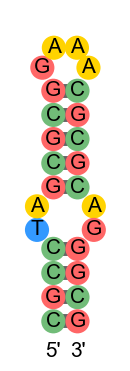

In [185]:
row = mm.iloc[4000,:]
draw_struct(row.RefSeq, row.TargetStruct)

In [189]:
np.unique(mm.topScaffold)

array(['GC'], dtype=object)

In [191]:
arr_v1.sort_values('Tm').iloc[]

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
SEQID,,,,,,,,,,,,,,,,,,,,,
MMTM1198,-6.525975,13.864264,-62.203652,-3.614248,5.010621,7.833929,-12.520447,16.454558,0.830124,0.909403,...,-2.257128,((.(.((....)).).)),0.66,-1.829500,-1.681525,66.666667,21.209771,1.255237,-23.4,-0.077575
BNNN829,-6.670409,17.764431,-61.789867,-2.629287,5.147361,16.073381,-25.945127,18.494065,0.901687,1.037849,...,-1.659130,((((((....)))..))),0.20,-1.635081,-1.476777,33.333333,24.408996,1.387909,-32.8,-0.106400
BNN5,-5.581248,5.637288,-23.973275,-3.124852,5.627890,7.585876,-10.027511,17.360302,0.687053,0.383884,...,-3.608250,((((((....)))..))),-2.68,-3.243060,-2.998979,55.555556,50.118161,-1.562323,-38.5,-0.115493
MMTM1333,-4.770891,15.207920,-30.467659,-1.584761,6.533386,18.169268,-57.126136,21.612603,0.620601,0.937509,...,-2.389820,((.(.((....)).).)),-0.36,-1.946775,-1.794594,61.111111,32.590414,0.405276,-28.1,-0.089441
BNNN2736,-6.583530,20.173226,-73.672916,-2.807356,6.899756,11.393933,-28.186285,17.520198,0.775904,1.286732,...,-2.396152,(((..(((....)))))),0.36,-2.194250,-1.951241,33.333333,23.041716,1.555153,-33.0,-0.107561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC2143,-30.244754,4.872433,-45.170265,-17.797973,59.989437,1.299909,56.970374,64.509140,-2.081039,0.308051,...,-7.375044,((((((....)))))),-7.25,-6.285362,-5.848049,68.750000,82.868705,-6.081149,-47.2,-0.128809
TETNN1137,-31.201794,3.675341,-45.592443,-21.331188,59.990053,1.109808,57.318400,64.677109,-2.186963,0.219980,...,-6.739760,((((((....)))))),-6.62,-5.579642,-5.138995,68.750000,74.826412,-5.391716,-49.6,-0.138578
TRINNN715,-32.982417,4.255016,-46.076076,-20.472890,59.990382,1.192257,57.132167,64.513128,-2.272676,0.260454,...,-4.754183,((((((...)))))),-4.39,-3.906072,-3.526701,66.666667,61.906504,-3.270750,-44.0,-0.127712


In [200]:
eg_df = df.query('SEQID == "MMCNNN2925"')

In [208]:
[x for x in eg_df.columns if x.startswith('Green')]

['Green07_Cy3',
 'Green09_Quench',
 'Green12_20.0',
 'Green13_22.5',
 'Green14_25.0',
 'Green15_27.5',
 'Green16_30.0',
 'Green17_32.5',
 'Green18_35.0',
 'Green19_37.5',
 'Green20_40.0',
 'Green21_42.5',
 'Green22_45.0',
 'Green23_47.5',
 'Green24_50.0',
 'Green25_52.5',
 'Green26_55.0',
 'Green27_57.5',
 'Green28_60.0',
 'Green29_20.0']

In [210]:
from nnn import train_nn as tnn
mydata = tnn.MyData()
mydata.load_everything()

In [214]:
curve = pd.read_csv('data/models/raw/arr_p_unfold_n=31000.csv', index_col=0)

(0.0, 1.0)

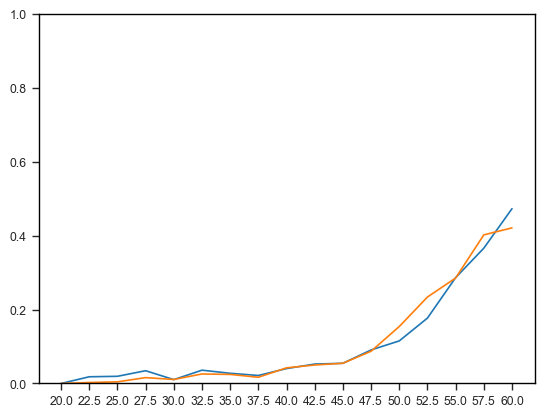

In [226]:
plt.plot(curve.loc[['MMCNNN2925', 'TETNN1137']].T)
plt.ylim([0,1])

In [232]:
np.argmax(arr_v1.RefSeq.apply(util.get_GC_content))

20519

In [235]:
arr_v1.query('RefSeq == "GTCAGGGAAACCTGAC"')

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
SEQID,,,,,,,,,,,,,,,,,,,,,
WC1375,-32.515649,2.333734,-43.057576,-25.513897,52.272962,0.784343,49.734161,55.226463,-1.696434,0.085923,...,-6.011584,((((((....)))))),-5.91,-4.983541,-4.573978,56.25,71.335661,-4.584924,-46.0,-0.12926


# 88mM  vs 63mM

In [7]:
arr88 = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
arr63 = pd.read_csv('./data/models/processed/arr_v1_1M_75mM_n=27732.csv', index_col=0)

arr_joint = arr88[['dG_37', 'Tm']].join(arr63[['dG_37', 'Tm']], lsuffix='_88', rsuffix='_63').dropna()

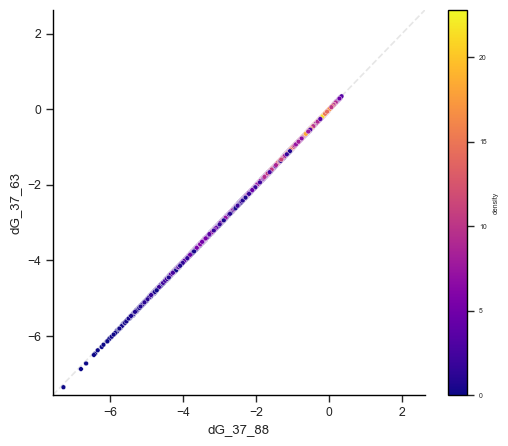

In [8]:
plotting.plot_colored_scatter_comparison(arr_joint, x='dG_37_88', y='dG_37_63')

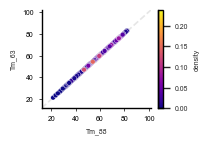

In [9]:
plotting.plot_colored_scatter_comparison(arr_joint, x='Tm_88', y='Tm_63')
util.beutify(plt.gca(), shrink=True)

-0.3364907936866075


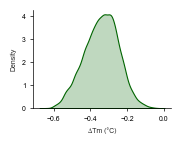

In [13]:
dTm = arr_joint['Tm_88'] - arr_joint['Tm_63']
sns.kdeplot(dTm, fill=True, color='darkgreen')
plt.xlabel('∆Tm (°C)')
util.beutify(plt.gca(), shrink=True)
print(np.median(dTm))

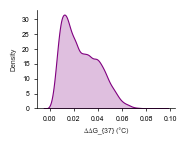

In [11]:
dTm = arr_joint['dG_37_88'] - arr_joint['dG_37_63']
sns.kdeplot(dTm, fill=True, color='purple')
plt.xlabel('∆∆G_{37} (°C)')
util.beutify(plt.gca(), shrink=True)

In [17]:
np.mean(arr.Tm_se)

1.2797041211212108

This is very bad because the offset in Tm is more than 2°C and not neglegible. May explain why Tm does not perform well in certain cases.

Will need to run things again...

Could be a good chance to clean up.

# Bulges

In [20]:
p_file = './models/lr_dict.pkl'
p_dict = fileio.read_pickle(p_file)

In [21]:
[x for x in p_dict['dG'].coef_df.index if x.startswith('bul')]

[]

In [6]:
annotation.loc['WC68', 'RefSeq']

'GAATTGGGAAACCAATTC'